# Worst-case OMP tests

In [1]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Worst-case OMP algorithm

We construct a measurement basis $W_m$ based on a given approximation basis $V_n$. Our ambient space $V$ is $H_0^1([0,1])$. Here $V_n$ is the sinusoids, normalised in $H_0^1([0,1])$, so $V_n = \mathrm{span}\{\phi_1,\ldots,\phi_n\}$, where $\phi_k = \frac{\sqrt{2}}{\pi k} \sin(k \pi x)$.

The measurements are assumed to be point evaluations, which have representer in $H_0^1$ of
$$
\omega_{x_0}(x) = \frac{1}{\sqrt{x_0 (1-x_0)}}
\begin{cases}
x (1 - x_0) & \text{for } x \le x_0 \\
(1 - x) x_0 & \text{for } x > x_0
\end{cases}
$$

This implementation of the algorithm finds the vector $v\in V_n$ that is furthest possible from $W_m$, that is at each step we look for 
$$
v_k = argmax_{v\in V_n,\, \|v\|=1} \| v - P_{W_{k-1}} v \|
$$
and then find the dictionary element most closely aligned with this vector
$$
\omega_k 
= \mathrm{argmax}_{\omega\in\mathcal{D}} |\left\langle \omega, v_k - P_{W_{k-1}} v_k \right\rangle| 
$$
It is because of the selection of $v_k$ that we call this the _worst-case_ approach. We find $v_k$ through the SVD decomposition of the cross-gramian of $W_{k-1}$ and $V_n$. Although this is expensive, it works out quite well as the slowest part of the algorithm is actually the dot product search through $\mathcal{D}$, as the SVD code is written in 

### Lets look at $\beta(V_n, W_m)$ for our worst-case OMP basis and a random basis for comparison
Note that this calculation is done for a small dictionary that only has $N=10^3$ elements, to save time, however as we saw in the collective-OMP, the size of the dictionary doesn't have a huge impact in this example.

In [2]:
N = 1e3
dictionary = pat.make_unif_dictionary(N)

ns = [20,40]
np.random.seed(3)
#n = 20
m = 200
bs_comp = np.zeros((len(ns), m))
bs_wcomp = np.zeros((len(ns), m))
bs_rand = np.zeros((len(ns), m))

Vn = pat.make_sin_basis(ns[-1])
Wms_comp = []
Wms_wcomp = []
Wms_rand = []

for j, n in enumerate(ns):

    gbc = pat.CollectiveOMP(m, dictionary, Vn.subspace(slice(0,n)), verbose=True)
    Wm_comp = gbc.construct_basis()
    Wms_comp.append(Wm_comp)
    Wm_comp_o = Wm_comp.orthonormalise()
    
    wcgbc = pat.WorstCaseOMP(m, dictionary, Vn.subspace(slice(0,n)), verbose=True)
    Wm_wcomp = wcgbc.construct_basis()
    Wms_wcomp.append(Wm_wcomp)
    Wm_wcomp_o = Wm_wcomp.orthonormalise()

    Wm_rand = pat.make_random_delta_basis(m)
    Wms_rand.append(Wm_rand)
    Wm_rand_o = Wm_rand.orthonormalise()

    BP_comp_l = pat.BasisPair(Wm_comp_o, Vn.subspace(slice(0,n)))
    BP_wcomp_l = pat.BasisPair(Wm_wcomp_o, Vn.subspace(slice(0,n)))    
    BP_rand_l = pat.BasisPair(Wm_rand_o, Vn.subspace(slice(0,n)))
    for i in range(n, m):
        BP_comp = BP_comp_l.subspace(Wm_indices=slice(0,i))
        bs_comp[j, i] = BP_comp.beta()

        BP_wcomp =  BP_wcomp_l.subspace(Wm_indices=slice(0,i))
        bs_wcomp[j, i] = BP_wcomp.beta()
        
        BP_rand = BP_rand_l.subspace(Wm_indices=slice(0,i))
        bs_rand[j, i] = BP_rand.beta()



Generating basis from greedy algorithm with dictionary: 
i 	 || P_Vn (w - P_Wm w) ||
1 : 	 81 	 0.8571343821013426
2 : 	 957 	 0.8478519661242144
3 : 	 812 	 0.5929925737817036
4 : 	 243 	 0.5199125278326097
5 : 	 26 	 0.48416159219343224
6 : 	 896 	 0.3199274022393139
7 : 	 675 	 0.29852256538188526
8 : 	 371 	 0.26312642476426895
9 : 	 149 	 0.26203418166487313
10 : 	 743 	 0.14756995955527202
11 : 	 597 	 0.13852504744923794
12 : 	 443 	 0.12731472282743972
13 : 	 304 	 0.12308941055655287
14 : 	 850 	 0.10431733420279948
15 : 	 191 	 0.08760532948172639
16 : 	 967 	 0.07296362498788497
17 : 	 114 	 0.05720132587427966
18 : 	 914 	 0.04963931221244638
19 : 	 46 	 0.04564995435059704
20 : 	 553 	 0.03924205166611702
21 : 	 702 	 0.03479393843544869
22 : 	 628 	 0.03430621290109172
23 : 	 475 	 0.032058761270104964
24 : 	 403 	 0.030850765953742608
25 : 	 763 	 0.028143467877218515
26 : 	 269 	 0.025898318452608114
27 : 	 331 	 0.023928063825036865
28 : 	 213 	 0.012521433198424392


32 : 	 829 	 0.0758314822212936
33 : 	 678 	 0.08846703407402506
34 : 	 86 	 0.09812533346301332
35 : 	 287 	 0.0804349457719438
36 : 	 423 	 0.041137098173547736
37 : 	 715 	 0.03920794319200221
38 : 	 548 	 0.02930437543383463
39 : 	 462 	 0.044899013848770236
40 : 	 582 	 0.03892934999640993
41 : 	 855 	 0.035170075779073426
42 : 	 748 	 0.029387772193012057
43 : 	 250 	 0.02827666420294061
44 : 	 51 	 0.032061949922191385
45 : 	 217 	 0.029536436225761367
46 : 	 898 	 0.029448358633116678
47 : 	 943 	 0.02772715611692253
48 : 	 799 	 0.023062566089422143
49 : 	 391 	 0.020338864635012888
50 : 	 772 	 0.024740498574057385
51 : 	 512 	 0.020401659020400864
52 : 	 144 	 0.02124667637300383
53 : 	 629 	 0.02030656043144849
54 : 	 7 	 0.02113415772701098
55 : 	 364 	 0.01676246877975507
56 : 	 485 	 0.019133303352453238
57 : 	 120 	 0.02243334733343133
58 : 	 649 	 0.02035511663655508
59 : 	 339 	 0.019426522612555466
60 : 	 315 	 0.018408121758805226
61 : 	 912 	 0.02102775212962027
62

71 : 	 54 	 0.0036964320051864844
72 : 	 69 	 0.0036844212986242913
73 : 	 683 	 0.0032043616837064363
74 : 	 880 	 0.0031415991805134116
75 : 	 171 	 0.0030849813836726706
76 : 	 822 	 0.0030316534700067267
77 : 	 32 	 0.002990503358515764
78 : 	 398 	 0.002913632838249608
79 : 	 561 	 0.0024793222004745315
80 : 	 20 	 0.002337279219278609
81 : 	 519 	 0.002336035518681272
82 : 	 831 	 0.0023167851668588015
83 : 	 136 	 0.0022530553975245254
84 : 	 155 	 0.0020712047289520807
85 : 	 414 	 0.0019462525885597269
86 : 	 8 	 0.0017865619197280655
87 : 	 385 	 0.0016904938139778202
88 : 	 904 	 0.0016707618434523971
89 : 	 729 	 0.0016450003910735388
90 : 	 95 	 0.0016103733974262371
91 : 	 81 	 0.0015384710455399074
92 : 	 893 	 0.0015173377627354025
93 : 	 771 	 0.0013711861821092393
94 : 	 745 	 0.0013760555250092125
95 : 	 181 	 0.001305659672666535
96 : 	 220 	 0.0012924835239814247
97 : 	 880 	 0.00128580149288896
98 : 	 235 	 0.001227166214850498
99 : 	 120 	 0.001169314958116186
10

107 : 	 535 	 0.009583035942771028
108 : 	 85 	 0.013212918281339959
109 : 	 236 	 0.011569907302957955
110 : 	 271 	 0.008337609777471139
111 : 	 115 	 0.008516827280696276
112 : 	 617 	 0.008510724102236203
113 : 	 419 	 0.008972419095767679
114 : 	 838 	 0.008596667499134146
115 : 	 872 	 0.008271195115773136
116 : 	 427 	 0.007561951809147205
117 : 	 225 	 0.008344790355307469
118 : 	 2 	 0.015333130733107256
119 : 	 164 	 0.01153403452673904
120 : 	 602 	 0.008911138074273753
121 : 	 715 	 0.006874482550208831
122 : 	 157 	 0.007657853215559167
123 : 	 55 	 0.02047025287155821
124 : 	 401 	 0.008271451561340064
125 : 	 400 	 0.007961496907473997
126 : 	 462 	 0.008908283076134886
127 : 	 295 	 0.013805106599507705
128 : 	 485 	 0.007738015077439812
129 : 	 339 	 0.008525546377418126
130 : 	 328 	 0.006128442610695395
131 : 	 201 	 0.006701873262323917
132 : 	 31 	 0.007493278373163714
133 : 	 676 	 0.008478099227666756
134 : 	 534 	 0.007477822475623619
135 : 	 618 	 0.00819482606

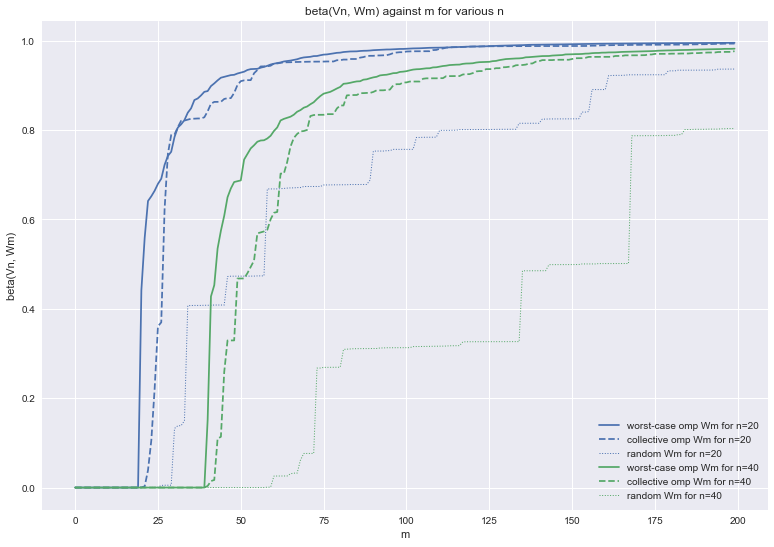

In [3]:
sns.set_palette("deep")
cp = sns.color_palette()

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title='beta(Vn, Wm) against m for various n')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

for i, n in enumerate(ns):
    plt.plot(range(m), bs_wcomp[i, :], label='worst-case omp Wm for n={0}'.format(n), color=cp[i])#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
    plt.plot(range(m), bs_comp[i, :], '--', label='collective omp Wm for n={0}'.format(n), color=cp[i])#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
    plt.plot(range(m), bs_rand[i, :], ':', label='random Wm for n={0}'.format(n), color=cp[i], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel='beta(Vn, Wm)')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.show()

In [4]:
bs_unif_int = np.zeros((len(ns), m))
Vn = pat.make_sin_basis(ns[-1])

Wms_unif_int = []

for j, n in enumerate(ns):
    for i in range(n, m):
        Wm_unif_int = pat.Basis([pat.FuncVector(params=[[x]],coeffs=[[1.0]],funcs=['H1UIDelta']) for x in np.linspace(0.0, 1.0, i, endpoint=False)+0.5/i])
        Wm_unif_int_o = Wm_unif_int.orthonormalise()

        BP_ui = pat.BasisPair(Wm_unif_int_o, Vn.subspace(slice(0,n)))
        bs_unif_int[j, i] = BP_ui.beta()

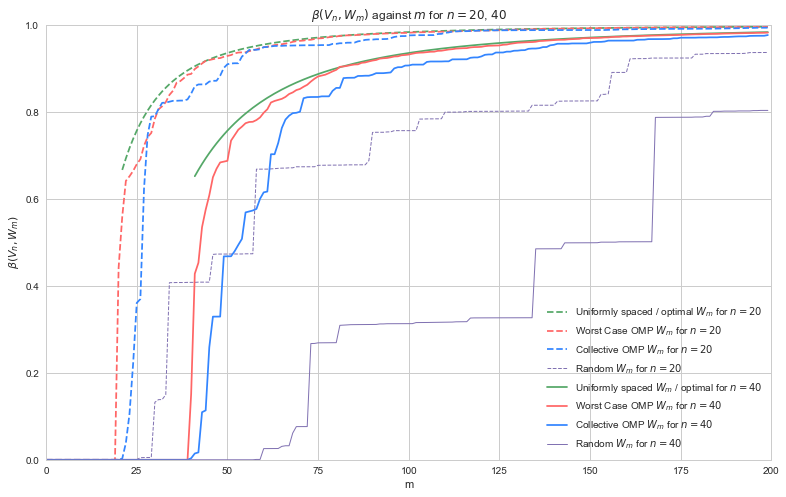

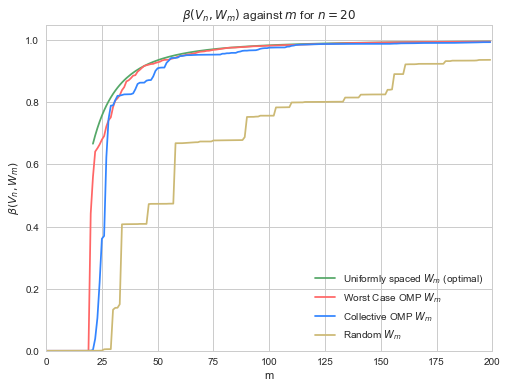

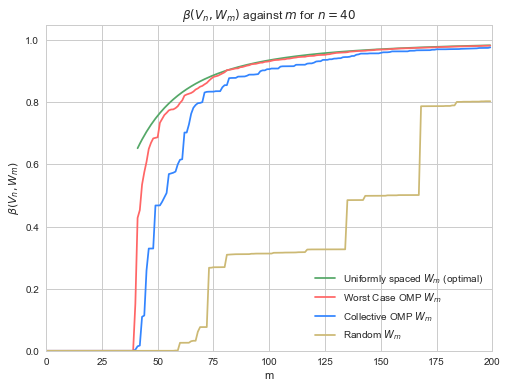

In [24]:
sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

axs = []
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$, $40$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

#for i, n in enumerate(ns):
i=0
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], '--', label=r'Uniformly spaced / optimal $W_m$ for $n={{{0}}}$'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], '--', label=r'Worst Case OMP $W_m$ for $n={{{0}}}$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], '--', label=r'Collective OMP $W_m$ for $n={{{0}}}$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], '--', label=r'Random $W_m$ for $n={{{0}}}$'.format(n), color=cp[3], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))
i=1
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], label=r'Uniformly spaced $W_m$ / optimal for $n={{{0}}}$'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], label=r'Worst Case OMP $W_m$ for $n={{{0}}}$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], label=r'Collective OMP $W_m$ for $n={{{0}}}$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], label=r'Random $W_m$ for $n={{{0}}}$'.format(n), color=cp[3], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,200], ylim=[0,1])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('WCOMPvsCOMPvsUnif.pdf')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

#for i, n in enumerate(ns):
i=0
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], label=r'Uniformly spaced $W_m$ (optimal)'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], label=r'Worst Case OMP $W_m$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], label=r'Collective OMP $W_m$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], label=r'Random $W_m$'.format(n), color=cp[4])#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,200], ylim=[0,1.05])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('WCOMPvsCOMPvsUnif_20.pdf')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=40$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

i=1
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], label=r'Uniformly spaced $W_m$ (optimal)'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], label=r'Worst Case OMP $W_m$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], label=r'Collective OMP $W_m$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], label=r'Random $W_m$'.format(n), color=cp[4])#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,200], ylim=[0,1.05])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('WCOMPvsCOMPvsUnif_40.pdf')
plt.show()

### Fix a minimum $\beta^*$ and vary $n$, plot resulting $m^*$

This result is actually found using the script ```scripts/01_m_star_tests.py``` and the accompanying ```make_01_scripts.py``` which produces the batch job for cluster computers. Here we just import the results which are found in csv files imported from the computing cluster.

Note that this, at present, is for the value $\beta^* = 0.5$.

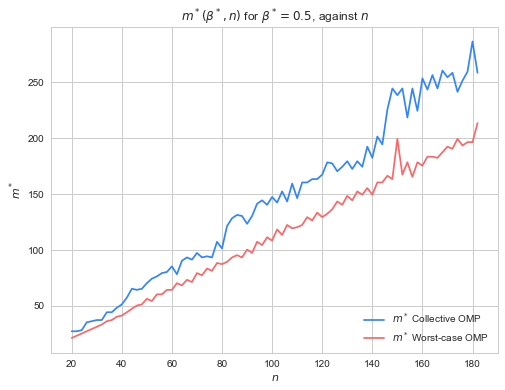

In [30]:
data_dir = '../scripts/'
comp_file = data_dir + 'comp_sin_m_star.csv'
wcomp_file = data_dir + 'wcomp_sin_m_star.csv'

ms_comp = np.loadtxt(comp_file)
ms_wcomp = np.loadtxt(wcomp_file)

sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

axs = []
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$m^*(\beta^*, n)$ for $\beta^*=0.5$, against $n$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

plt.plot(ms_comp[:,0], ms_comp[:,1], label=r'$m^*$ Collective OMP'.format(n), color=bl)
plt.plot(ms_wcomp[:,0], ms_wcomp[:,1], label=r'$m^*$ Worst-Case OMP'.format(n), color=re)

ax.set(xlabel='$n$', ylabel=r'$m^*$')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('m_star_COMP_vs_WCOMP.pdf')
plt.show()
